In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install folium==0.2.1
!pip install markupsafe==2.0.1
!pip install -U pandas-profiling

!pip install catboost
!pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.1 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=418a4b365ed6c3596f9a5378801c3a4110aa0a7fbada8a11548f12daa8626280
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1.post1
    Uninstalling folium-0.12.1.post1:
      Successfully uninstalled folium-0.12.1.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sys
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# import pandas_profiling

from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn import metrics

from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from collections import Counter
from flaml import AutoML

import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [4]:
%cd '/content/drive/MyDrive/Travel_product_application/'

/content/drive/MyDrive/Travel_product_application


In [5]:
# reproducibility
def set_seed(seed_num):
  # tf.random.set_seed(seed_num)
  np.random.seed(seed_num)
  rn.seed(seed_num)
  os.environ['PYTHONHASHSEED']=str(seed_num)

seed_num = 42
set_seed(seed_num)

## **1. Load dataset**
- id : 샘플 아이디 | Age : 나이 | TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)
- CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급) 
- DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간
- Occupation : 직업 | Gender : 성별 | NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원
- NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수 | ProductPitched : 영업 사원이 제시한 상품
- PreferredPropertyStar : 선호 호텔 숙박업소 등급 | MaritalStatus : 결혼여부
- NumberOfTrips : 평균 연간 여행 횟수 | Passport : 여권 보유 여부 (0: 없음, 1: 있음)
- PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도 | OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)
- NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수
 | Designation : (직업의) 직급
- MonthlyIncome : 월 급여 | **ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함)**

In [6]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28.0,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,3.0,Married,3.0,0,1,0,1.0,Executive,20384.0,0
1,2,34.0,Self Enquiry,3,NaN,Small Business,Female,2,4.0,Deluxe,4.0,Single,1.0,1,5,1,0.0,Manager,19599.0,1
2,3,45.0,Company Invited,1,NaN,Salaried,Male,2,3.0,Deluxe,4.0,Married,2.0,0,4,1,0.0,Manager,NaN,0
3,4,29.0,Company Invited,1,7.0,Small Business,Male,3,5.0,Basic,4.0,Married,3.0,0,4,0,1.0,Executive,21274.0,1
4,5,42.0,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,3.0,Divorced,2.0,0,3,1,0.0,Manager,19907.0,0


In [7]:
train.isnull().sum()

id                            0
Age                          94
TypeofContact                10
CityTier                      0
DurationOfPitch             102
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar        10
MaritalStatus                 0
NumberOfTrips                57
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

In [8]:
test.isnull().sum()

id                            0
Age                         132
TypeofContact                15
CityTier                      0
DurationOfPitch             149
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            32
ProductPitched                0
PreferredPropertyStar        16
MaritalStatus                 0
NumberOfTrips                83
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     39
Designation                   0
MonthlyIncome               133
dtype: int64

In [9]:
print(train.shape)
print(test.shape)

(1955, 20)
(2933, 19)


In [10]:
df_train = train.copy()
df_test = test.copy()

## **2. Make dataset**

- Fill nan : `Age`, `TypeofContact`, `DurationOfPitch`, `NumberOfFollowups`, `PreferredPropertyStar`, `NumberOfTrips`, `NumberOfChildrenVisiting`, `MonthlyIncome`

In [11]:
df_train['MonthlyIncome'] = df_train['MonthlyIncome'].fillna(df_train.groupby('Designation')['MonthlyIncome'].transform('mean'))
df_test['MonthlyIncome'] = df_test['MonthlyIncome'].fillna(df_test.groupby('Designation')['MonthlyIncome'].transform('mean'))

In [12]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby('Designation')['Age'].transform('mean'))
df_test['Age'] = df_test['Age'].fillna(df_test.groupby('Designation')['Age'].transform('mean'))

In [13]:
nan_col = ['TypeofContact', 'NumberOfFollowups', 'DurationOfPitch', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting']

imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(df_train[nan_col])
df_train[nan_col] = imputer.transform(df_train[nan_col])
df_test[nan_col] = imputer.transform(df_test[nan_col])

In [14]:
df_train.isnull().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
dtype: int64

In [15]:
df_test.isnull().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [16]:
print(df_train.shape)
print(df_test.shape)

(1955, 20)
(2933, 19)


In [17]:
categorical_fts = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Passport', 'OwnCar', 'Designation']

In [18]:
for i in range(len(categorical_fts)):
  print(categorical_fts[i], ':')
  print(df_train[categorical_fts[i]].unique())

TypeofContact :
['Company Invited' 'Self Enquiry']
Occupation :
['Small Business' 'Salaried' 'Large Business' 'Free Lancer']
Gender :
['Male' 'Female' 'Fe Male']
ProductPitched :
['Basic' 'Deluxe' 'King' 'Standard' 'Super Deluxe']
MaritalStatus :
['Married' 'Single' 'Divorced' 'Unmarried']
Passport :
[0 1]
OwnCar :
[0 1]
Designation :
['Executive' 'Manager' 'VP' 'Senior Manager' 'AVP']


In [19]:
df_train['Gender'] = df_train['Gender'].str.replace('Fe Male', 'Female')
df_test['Gender'] = df_test['Gender'].str.replace('Fe Male', 'Female')

In [20]:
print(df_train['Gender'].unique())

['Male' 'Female']


In [23]:
df_train = df_train.astype({'DurationOfPitch':'int', 'NumberOfFollowups':'int', 'PreferredPropertyStar':'int', 'NumberOfTrips':'int', 'NumberOfChildrenVisiting':'int', 'Age':'int'})
df_test = df_test.astype({'DurationOfPitch':'int', 'NumberOfFollowups':'int', 'PreferredPropertyStar':'int', 'NumberOfTrips':'int', 'NumberOfChildrenVisiting':'int', 'Age':'int'})

In [24]:
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28,Company Invited,1,10,Small Business,Male,3,4,Basic,3,Married,3,0,1,0,1,Executive,20384.000000,0
1,2,34,Self Enquiry,3,9,Small Business,Female,2,4,Deluxe,4,Single,1,1,5,1,0,Manager,19599.000000,1
2,3,45,Company Invited,1,9,Salaried,Male,2,3,Deluxe,4,Married,2,0,4,1,0,Manager,22614.373397,0
3,4,29,Company Invited,1,7,Small Business,Male,3,5,Basic,4,Married,3,0,4,0,1,Executive,21274.000000,1
4,5,42,Self Enquiry,3,6,Salaried,Male,2,3,Deluxe,3,Divorced,2,0,3,1,0,Manager,19907.000000,0


In [25]:
cat_fts = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']

In [26]:
la_train = df_train.copy()

for i in range(len(cat_fts)):
  encoder = LabelEncoder()
  la_train[cat_fts[i]] = encoder.fit_transform(la_train[cat_fts[i]])

In [27]:
la_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28,0,1,10,3,1,3,4,0,3,1,3,0,1,0,1,1,20384.000000,0
1,2,34,1,3,9,3,0,2,4,1,4,2,1,1,5,1,0,2,19599.000000,1
2,3,45,0,1,9,2,1,2,3,1,4,1,2,0,4,1,0,2,22614.373397,0
3,4,29,0,1,7,3,1,3,5,0,4,1,3,0,4,0,1,1,21274.000000,1
4,5,42,1,3,6,2,1,2,3,1,3,0,2,0,3,1,0,2,19907.000000,0


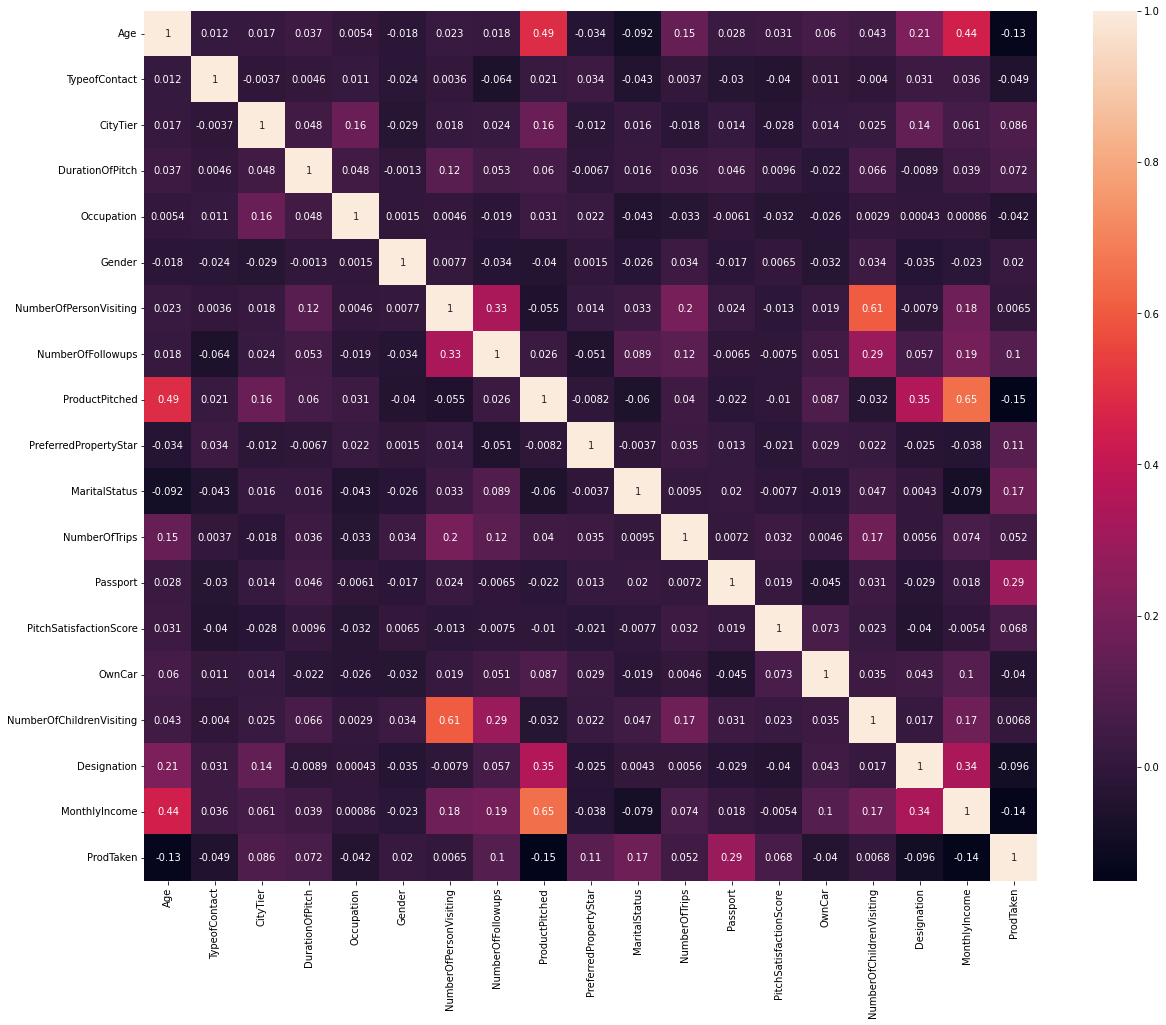

In [32]:
plt.figure(figsize = (20,16))
sns.heatmap(la_train.drop('id', axis = 1).corr(), annot=True)
plt.show()

In [33]:
# One-hot encoding
train_data = pd.get_dummies(df_train)
test_data = pd.get_dummies(df_test)

print(train_data.columns)
print(test_data.columns)

Index(['id', 'Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome', 'ProdTaken',
       'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry',
       'Occupation_Free Lancer', 'Occupation_Large Business',
       'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female',
       'Gender_Male', 'ProductPitched_Basic', 'ProductPitched_Deluxe',
       'ProductPitched_King', 'ProductPitched_Standard',
       'ProductPitched_Super Deluxe', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Unmarried', 'Designation_AVP', 'Designation_Executive',
       'Designation_Manager', 'Designation_Senior Manager', 'Designation_VP'],
      dtype='object')
Index(['id', 'Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollo

In [35]:
train_id = train_data['id']
test_id = test_data['id']

train_x = train_data.drop(['id', 'ProdTaken', 'NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis = 1)
test_x = test_data.drop(['id', 'NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis = 1)

train_y = train_data['ProdTaken']

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(1955, 32)
(1955,)
(2933, 32)


## **3. Modeling**

In [36]:
MODEL_TIME_BUDGET = 60*10
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["lgbm"]

auto_lgbm = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_lgbm.fit(train_x, train_y, **params)

[flaml.automl: 09-02 03:12:47] {2565} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 09-02 03:12:47] {2567} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 09-02 03:12:47] {2570} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 09-02 03:12:47] {2689} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 09-02 03:12:47] {2831} INFO - List of ML learners in AutoML Run: ['lgbm']
INFO:flaml.automl:List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-02 03:12:47] {3133} INFO - iteration 0, current learner lgbm
INFO:flaml.automl:iteration 0, current learner lgbm
[flaml.automl: 09-02 03:12:47] {3267} INFO - Estimated sufficient time budget=1668s. Estimated necessary time budget=2s.
INFO:flaml.automl:Estimated sufficient time budget=1668s. Estimated necessary time budget=2s.
[flaml.automl: 09-02 03:12:47] 

In [37]:
MODEL_TIME_BUDGET = 60*10
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["xgboost"]

auto_xgb = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_xgb.fit(train_x, train_y, **params)

[flaml.automl: 09-02 03:22:47] {2565} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 09-02 03:22:47] {2567} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 09-02 03:22:47] {2570} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 09-02 03:22:47] {2689} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 09-02 03:22:47] {2831} INFO - List of ML learners in AutoML Run: ['xgboost']
INFO:flaml.automl:List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 09-02 03:22:47] {3133} INFO - iteration 0, current learner xgboost
INFO:flaml.automl:iteration 0, current learner xgboost
[flaml.automl: 09-02 03:22:47] {3267} INFO - Estimated sufficient time budget=2496s. Estimated necessary time budget=2s.
INFO:flaml.automl:Estimated sufficient time budget=2496s. Estimated necessary time budget=2s.
[flaml.automl: 09-0

In [38]:
MODEL_TIME_BUDGET = 60*10
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["rf"]

auto_rf = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_rf.fit(train_x, train_y, **params)

[flaml.automl: 09-02 03:32:46] {2565} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 09-02 03:32:46] {2567} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 09-02 03:32:46] {2570} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 09-02 03:32:46] {2689} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 09-02 03:32:46] {2831} INFO - List of ML learners in AutoML Run: ['rf']
INFO:flaml.automl:List of ML learners in AutoML Run: ['rf']
[flaml.automl: 09-02 03:32:46] {3133} INFO - iteration 0, current learner rf
INFO:flaml.automl:iteration 0, current learner rf
[flaml.automl: 09-02 03:32:47] {3267} INFO - Estimated sufficient time budget=11889s. Estimated necessary time budget=12s.
INFO:flaml.automl:Estimated sufficient time budget=11889s. Estimated necessary time budget=12s.
[flaml.automl: 09-02 03:32:47] {331

In [39]:
MODEL_TIME_BUDGET = 60*10
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["extra_tree"]

auto_ext = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_ext.fit(train_x, train_y, **params)

[flaml.automl: 09-02 03:42:43] {2565} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 09-02 03:42:43] {2567} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 09-02 03:42:43] {2570} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 09-02 03:42:43] {2689} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 09-02 03:42:43] {2831} INFO - List of ML learners in AutoML Run: ['extra_tree']
INFO:flaml.automl:List of ML learners in AutoML Run: ['extra_tree']
[flaml.automl: 09-02 03:42:43] {3133} INFO - iteration 0, current learner extra_tree
INFO:flaml.automl:iteration 0, current learner extra_tree
[flaml.automl: 09-02 03:42:44] {3267} INFO - Estimated sufficient time budget=13016s. Estimated necessary time budget=13s.
INFO:flaml.automl:Estimated sufficient time budget=13016s. Estimated necessary time budget=13s.
[fl

In [40]:
lightgbm = LGBMClassifier(colsample_bytree=0.7771134059384035,
               learning_rate=0.48133351674517444, max_bin=7,
               min_child_samples=8, n_estimators=212, num_leaves=20,
               reg_alpha=0.0009765625, reg_lambda=0.5956077440731764,
               verbose=-1, seed = seed_num)

lightgbm.fit(train_x, train_y)

LGBMClassifier(colsample_bytree=0.7771134059384035,
               learning_rate=0.48133351674517444, max_bin=7,
               min_child_samples=8, n_estimators=212, num_leaves=20,
               reg_alpha=0.0009765625, reg_lambda=0.5956077440731764, seed=42,
               verbose=-1)

In [41]:
xgboost =  XGBClassifier(colsample_bylevel=0.8722623931797018,
              colsample_bytree=0.9394791603033996, grow_policy='lossguide',
              learning_rate=1.0, max_depth=0, max_leaves=341,
              min_child_weight=0.14954196794254102, n_estimators=177, n_jobs=-1,
              reg_alpha=0.0027845800967488325, reg_lambda=1.9836090025204023,
              subsample=0.9169953782672334, tree_method='hist',
              use_label_encoder=False, verbosity=0, seed = seed_num)

xgboost.fit(train_x, train_y)

XGBClassifier(colsample_bylevel=0.8722623931797018,
              colsample_bytree=0.9394791603033996, grow_policy='lossguide',
              learning_rate=1.0, max_depth=0, max_leaves=341,
              min_child_weight=0.14954196794254102, n_estimators=177, n_jobs=-1,
              reg_alpha=0.0027845800967488325, reg_lambda=1.9836090025204023,
              seed=42, subsample=0.9169953782672334, tree_method='hist',
              use_label_encoder=False, verbosity=0)

In [42]:
rf =  RandomForestClassifier(max_features=0.260908480986029, max_leaf_nodes=251,
                       n_estimators=257, n_jobs=-1, random_state = seed_num)

rf.fit(train_x, train_y)

RandomForestClassifier(max_features=0.260908480986029, max_leaf_nodes=251,
                       n_estimators=257, n_jobs=-1, random_state=42)

In [43]:
ext =  ExtraTreesClassifier(criterion='entropy', max_features=0.3221556484089929,
                     max_leaf_nodes=585, n_estimators=31, n_jobs=-1, random_state = seed_num)

ext.fit(train_x, train_y)

ExtraTreesClassifier(criterion='entropy', max_features=0.3221556484089929,
                     max_leaf_nodes=585, n_estimators=31, n_jobs=-1,
                     random_state=42)

- Hard voting

In [44]:
print(test_x.shape)

(2933, 32)


In [45]:
lgb_p = lightgbm.predict(test_x)
xgb_p = xgboost.predict(test_x)
rf_p = rf.predict(test_x)
ext_p = ext.predict(test_x)

In [46]:
def mode(list):
    count = 0
    mode = 0;
    for x in list: 
        if list.count(x) > count:
            count = list.count(x)
            mode = x

    return mode

In [47]:
prediction = []
for i in range(0, len(lgb_p)):
    prediction.append(mode([lgb_p[i], xgb_p[i], rf_p[i], ext_p[i]]))
    # prediction.append(mode([lgb_p[i], xgb_p[i]]))

print(prediction)

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [50]:
sample_submission = pd.read_csv('dataset/sample_submission.csv')
sample_submission['ProdTaken'] = prediction

sample_submission.to_csv('hard_vt4++.csv',index = False)

In [51]:
sample_submission.head()

,id,ProdTaken
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
